In [3]:
import os
import matplotlib
matplotlib.use('Agg') 
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from dateutil.parser import parse as dtparse

import matplotlib.colors as colors
import sunpy
from sunpy import map
from sunpy.map import make_fitswcs_header
from sunpy.coordinates.frames import HeliocentricEarthEcliptic,HeliographicStonyhurst

import numpy as np
import mpld3




%matplotlib notebook
CMAP='RdPu'
def create_STIX_map(fits_filename,  solo_hee,   map_name=''): 

    """
    Converts the input FITS to a standard Sunpy Solar map, by
    returning the map containing the STIX source.

    Parameters
    ----
    fits_filename: str
        FITS filename 
    solo_hee:  Quantity(u.km)
        solar orbiter coordinates in the HeliocentricEarthEcliptic reference frame
    map_name: str, optional
        map name, 
        
    Returns
    ---
    stix_map: sunpy.map
        STIX map
    indices:  np.array
        pixel indices at maximum
    header:  dict
        fits file primary HDUlist header

    """
    hdul=fits.open(fits_filename)
    header=hdul[0].header
    obs_time=header['DATE_OBS']
    
    # Convert the string date and time to datetime.datetime
    datetime_map = dtparse(obs_time)
    # Obtain the HEE coordinates of Solar Orbiter

    solo_hee = HeliocentricEarthEcliptic(solo_hee,
                                              obstime=Time(datetime_map).isot,
                                              representation_type='cartesian')
    image_center=[0,0];
    image_center[0]=header['NAXIS1']/2.+0.5 - header['CRPIX1'] #
    image_center[1]=header['NAXIS2']/2.+0.5 - header['CRPIX2']
    print(image_center)
    # Set the coordinates of the reference pixel of the STIX map
    stix_ref_coord = SkyCoord(image_center[0]*u.arcsec, 
                              image_center[1]*u.arcsec,
                            
                              obstime=datetime_map,
                              observer=solo_hee.transform_to(HeliographicStonyhurst(obstime=datetime_map)),
                              frame='helioprojective')
    
    # Get the distance of Solar Orbiter from the Sun (center)

    # Create a FITS header containing the World Coordinate System (WCS) information
    scale=np.array([header['CDELT1'], header['CDELT2']])
    

    out_header = make_fitswcs_header(hdul[0].data,
                                     coordinate=stix_ref_coord, 
                                     #reference_pixel=np.array([header['CRPIX1'], header['CRPIX2']])*u.pixel,
                                     
                                     scale=scale*u.arcsec/u.pixel,
                                     rotation_angle =-header['CROTA1'] * u.deg,
                                     instrument=f"STIX {map_name} map",
                                     observatory="Solar Orbiter")
    #a=
    max_value=hdul[0].data.max()

    max_indices = np.where(hdul[0].data ==max_value)
  

    stix_map = map.Map(hdul[0].data, out_header)
 
    return stix_map, max_indices, header
def plot_flare_images(bp_image_fname, fw_image_filename, solo_hee):

    """
    Plot STIX image
    Parameters
    ----------
    bp_image_fname: str
        filename of fits file containing the Back-projection image
    fw_image_fname: str
        filename of fits file containing the forward-fit image    
     solo_hee:  Quantity(u.km)
        solar orbiter coordinates in the HeliocentricEarthEcliptic reference frame
    Returns
    -------
    ret:  dict
         json string to reproduce figures
    bmap: sunpy.map
        map of back-projection image
    fwmap: sunpy.map
        map of forward fit image

    """
    map_name=''
    ret={}
    bp_map, bp_maxidx,bp_header=create_STIX_map(bp_image_fname,   solo_hee,
                                            map_name)
    
  
    fw_map, fw_maxidx, fw_header=create_STIX_map(fw_image_filename,    
                                                solo_hee,map_name)

    title = f"{bp_header['ORIGIN']} \n {bp_header['DATE_OBS']} "
    fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
    ax_bp = fig.add_subplot(111, projection=bp_map)
    bp_map.plot( vmin=bp_map.max()*0.1, 
                    cmap=CMAP,#'sdoaia'+str(np.int(aia_map.meta['wavelnth'])), 
                    axes=ax_bp,  title="BP",)

    bp_map.draw_grid(color='k', ls='--', grid_spacing=10*u.deg)

    #ret['bp']=mpld3.fig_to_dict(fig)
    bp_map.draw_limb(axes=ax_bp, color='k',alpha=0.5)
    
    fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
    ax_bp_zoom = fig.add_subplot(111, projection=bp_map)

    bp_map.plot( vmin=bp_map.max()*0.1, 
                    cmap=CMAP,#'sdoaia'+str(np.int(aia_map.meta['wavelnth'])), 
                
                    axes=ax_bp_zoom, title='BP')
    bp_map.draw_limb(axes=ax_bp_zoom, color='k',alpha=0.5)
  

    bp_map.draw_grid(color='k', ls='--', grid_spacing=10*u.deg)
    ax_bp_zoom.set_xlim(bp_maxidx[1][0]-30, bp_maxidx[1][0]+30)
    ax_bp_zoom.set_ylim(bp_maxidx[0][0]-30, bp_maxidx[0][0]+30)
  
   
    #ret['bp_zoom']=mpld3.fig_to_dict(fig)
    
    fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
    ax_fw = fig.add_subplot(111, projection=fw_map)
    fw_map.plot(vmin=0., 
                            cmap=CMAP,#'sdoaia'+str(np.int(aia_map.meta['wavelnth'])), 
                
                            axes=ax_fw, title='FWD')
    fw_map.draw_limb(axes=ax_fw, color='k', alpha=0.5)

    fw_map.draw_grid(color='k', ls='--', grid_spacing=10*u.deg)
    

    #ret['fw']=mpld3.fig_to_dict(fig)

    return ret, bp_map, fw_map




[0.0, 0.0]
[1185.16271973, 619.516845703]


<IPython.core.display.Javascript object>


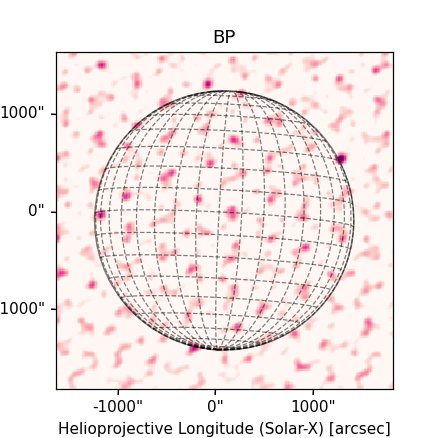

<IPython.core.display.Javascript object>


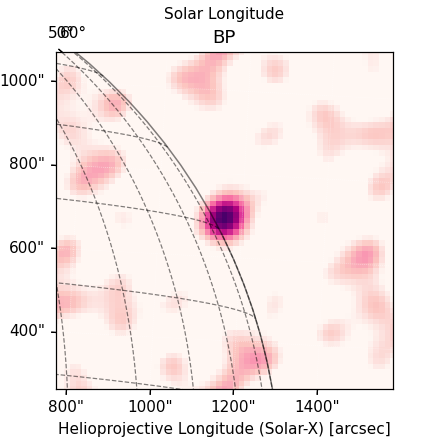

<IPython.core.display.Javascript object>


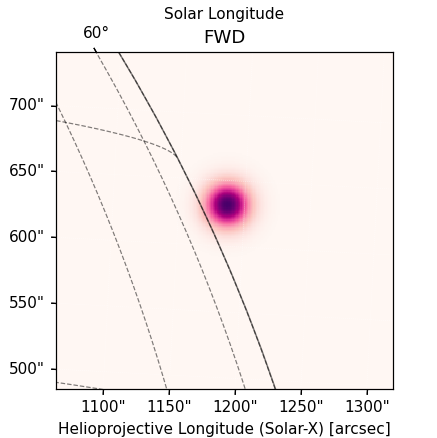

In [4]:

fw_fname='data/sci_9111_uid_2202155513_0_0_0_2022-02-15T18:11:49.918_fwfit.fits'
bp_fname='data/sci_9111_uid_2202155513_0_0_0_2022-02-15T18:11:49.918_bp.fits'

solo_hee =np.array([ 
                103180004.413567, 
                -32210695.9782662, 
                5137847.04012015
            ])*u.km

js, bmap, fwmap=plot_flare_images(bp_fname, fw_fname, solo_hee)


In [5]:
bmap.quicklook()